<a href="https://colab.research.google.com/github/cwirex/NeuralNetworks/blob/main/MNIST_DIGITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network Models

## Importy, wczytanie i przygotowanie danych

In [ ]:
# Imports
import keras.datasets.mnist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras import models, layers
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
sns.set()

In [ ]:
# Load data (digits) from dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [ ]:
# Normalize the data (0-255 -> 0-1)
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)
print(f'Pre-scale example:\n{X_train[0][202:207]}')
X_train = MinMaxScaler(copy=False).fit_transform(X_train)
X_test = MinMaxScaler(copy=False).fit_transform(X_test)
print(f'Post-scale example:\n{X_train[0][202:207]}')

# Convert target values to binary matrix
print(f'to_categorical example:\n{y_train[:2]}')
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(f'{y_train[:2]}')

# Reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

print(f'X_train.shape; y_train.shape {X_train.shape}; {y_train.shape}')
print(f'X_test.shape; y_test.shape {X_test.shape}; {y_test.shape}')

Pre-scale example:
[  0  49 238 253 253]
Post-scale example:
[0.         0.19215686 0.93333333 0.99215686 0.99215686]
to_categorical example:
[5 0]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
X_train.shape; y_train.shape (60000, 28, 28, 1); (60000, 10)
X_test.shape; y_test.shape (10000, 28, 28, 1); (10000, 10)


## CNN Model I
Model z wykorzystaniem sieci konwolucyjnej, której podstawą są 64 filtry i warstwa poolingowa.  
Model zawiera jedną dodatkową warstwę ukrytą.

In [ ]:
# Initialize model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28, 1), name='input'))
model.add(layers.Conv2D(64, (3,3), strides=(2, 2), padding="valid", activation='relu', name='convolutional'))    # 64 filtry 3x3, z krokiem co 2 i dozwolonym paddingiem
model.add(layers.MaxPooling2D((2,2), name='max_pooling'))
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(64, activation='relu', name='hidden'))
model.add(layers.Dense(10, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()
# plot_model(model, show_shapes=True)
# plot_model(model, show_shapes=True, show_layer_activations=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional (Conv2D)       (None, 13, 13, 64)        640       
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
hidden (Dense)               (None, 64)                147520    
_________________________________________________________________
output (Dense)               (None, 10)                650       
Total params: 148,810
Trainable params: 148,810
Non-trainable params: 0
_________________________________________________________________


Pierwsze trenowanie modelu batchami o większym rozmiarze

In [ ]:
val_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train model
fit_1 = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=128,
                    callbacks=[val_stop],
                    validation_data=(X_test, y_test)
                    )

Epoch 1/100
469/469 [==============================] - 12s 24ms/step - loss: 0.3522 - accuracy: 0.8952 - val_loss: 0.1529 - val_accuracy: 0.9549
Epoch 2/100
469/469 [==============================] - 11s 24ms/step - loss: 0.1174 - accuracy: 0.9648 - val_loss: 0.0948 - val_accuracy: 0.9710
Epoch 3/100
469/469 [==============================] - 11s 24ms/step - loss: 0.0814 - accuracy: 0.9756 - val_loss: 0.0760 - val_accuracy: 0.9751
Epoch 4/100
469/469 [==============================] - 11s 24ms/step - loss: 0.0634 - accuracy: 0.9805 - val_loss: 0.0617 - val_accuracy: 0.9791
Epoch 5/100
469/469 [==============================] - 11s 24ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.0543 - val_accuracy: 0.9822
Epoch 6/100
469/469 [==============================] - 12s 25ms/step - loss: 0.0437 - accuracy: 0.9868 - val_loss: 0.0465 - val_accuracy: 0.9846
Epoch 7/100
469/469 [==============================] - 18s 38ms/step - loss: 0.0373 - accuracy: 0.9894 - val_loss: 0.0445 - val_ac

Dotrenowanie modelu małymi batchami (możliwe osłabienie generalizacji).  
Zastosowałem dwa rygorystycznie ustawione parametry do wcześniejszego zatrzymywania procesu uczenia, aby uniknąć zjawiska overfittingu.

In [ ]:
val_stop2 = EarlyStopping(monitor='val_loss', patience=2)
val_stop2_B = EarlyStopping(monitor='val_accuracy', patience=3)

# Train model
fit_2 = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    steps_per_epoch=10,
                    callbacks=[val_stop2, val_stop2_B],
                    validation_data=(X_test, y_test)
                    )

Epoch 1/1000
10/10 [==============================] - 1s 98ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 0.0450 - val_accuracy: 0.9853
Epoch 2/1000
10/10 [==============================] - 1s 98ms/step - loss: 0.0592 - accuracy: 0.9875 - val_loss: 0.0508 - val_accuracy: 0.9832
Epoch 3/1000
10/10 [==============================] - 1s 152ms/step - loss: 0.0324 - accuracy: 0.9875 - val_loss: 0.0451 - val_accuracy: 0.9856


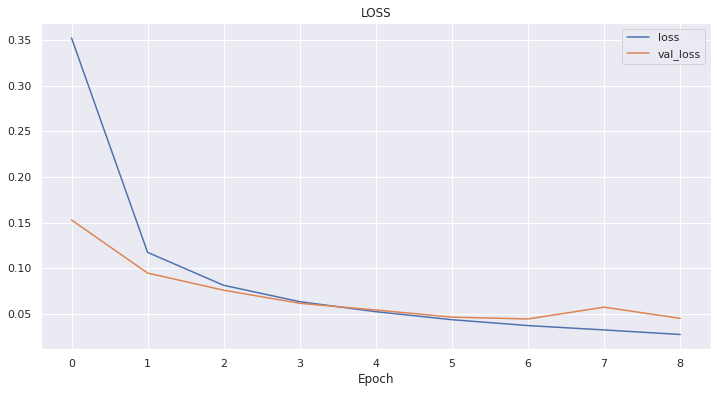

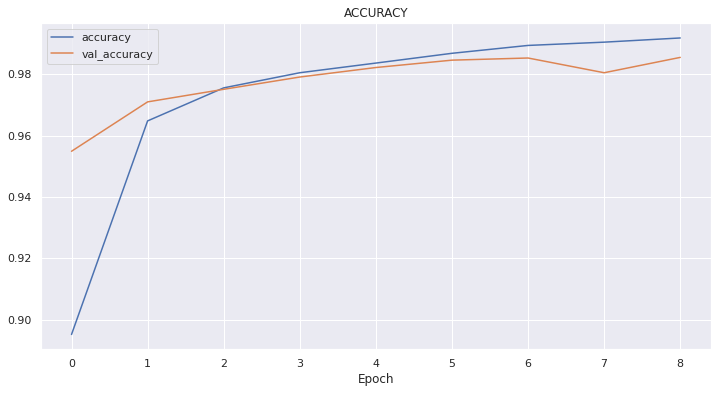

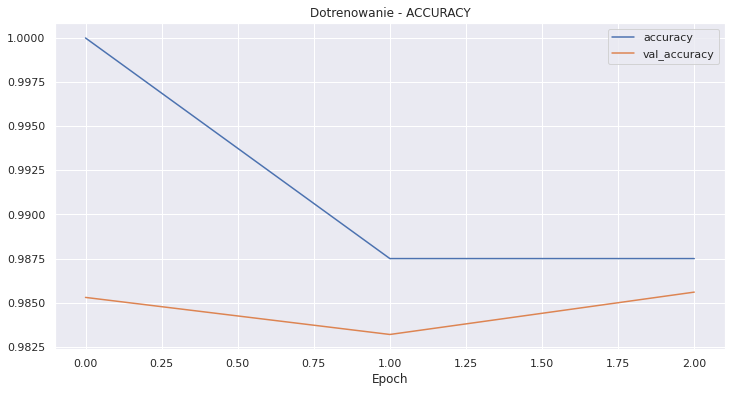

In [ ]:
# Plots for Model I
y_pred_1 = fit_1.model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(fit_1.history['loss'], '-', label='loss')
plt.plot(fit_1.history['val_loss'], '-', label='val_loss')
plt.xlabel("Epoch")
plt.title("LOSS")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(fit_1.history['accuracy'], '-', label='accuracy')
plt.plot(fit_1.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.title("ACCURACY")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(fit_2.history['accuracy'], '-', label='accuracy')
plt.plot(fit_2.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.title("Dotrenowanie - ACCURACY")
plt.legend()
plt.show()

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1131,    2,    0,    0,    0,    1,    0,    1,    0],
       [   2,    3, 1017,    0,    1,    0,    2,    6,    1,    0],
       [   1,    1,    5,  984,    0,   10,    0,    5,    4,    0],
       [   0,    0,    0,    0,  962,    0,    5,    2,    1,   12],
       [   1,    0,    0,    2,    0,  880,    5,    2,    1,    1],
       [   8,    2,    1,    0,    0,    3,  942,    0,    1,    1],
       [   0,    3,    6,    1,    0,    0,    0, 1017,    0,    1],
       [   4,    0,    4,    0,    1,    1,    1,    3,  957,    3],
       [   1,    5,    0,    2,    4,    2,    1,    3,    2,  989]])

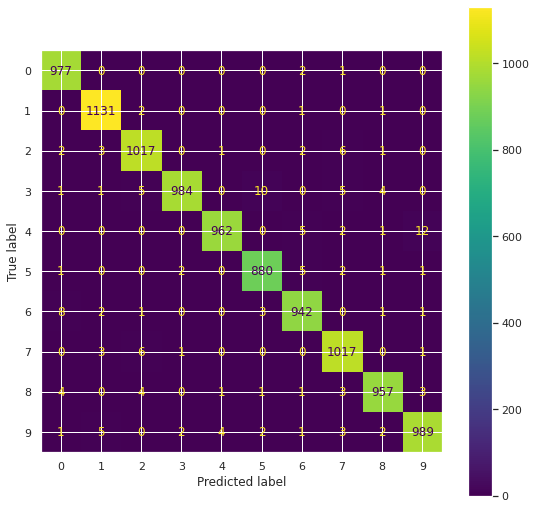

In [ ]:
# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(9, 9))
cmp.plot(ax=ax)
cm

#### Pomyłki modelu I
Poniżej przedstawiam kilka pierwszych próbek ze zbioru testowego, które zostały zaklasyfikowane **błędnie**. Pierwsza cyfra oznacza prawidłową odpowiedź, a za nią znajduje się odpowiedź modelu.

Misclassified on indexes:  [  8  18 247 320 445 448 449 582 659 740]  (first 10)


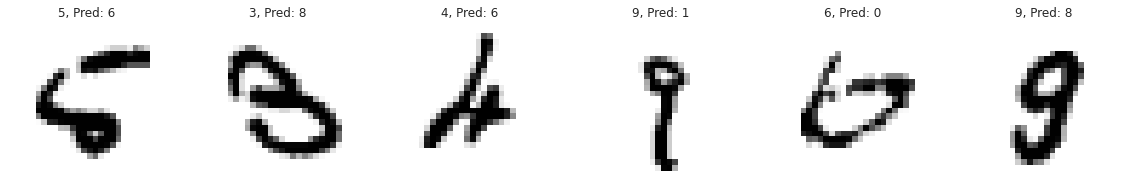

In [ ]:
# Get indexes of misclassifications
y_pred = np.argmax(y_pred_1, axis=1)
y_test_arg = np.argmax(y_test, axis=1)
mscl = y_test_arg != y_pred
mscl = mscl.nonzero()[0]
X_test_mscl = X_test[mscl]
y_pred_mscl = y_pred[mscl]
y_correct_mscl = y_test_arg[mscl]
print("Misclassified on indexes: ", mscl[:10], " (first 10)")

# Show misclassifications
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for ax, image, prediction, correct in zip(axes, X_test_mscl, y_pred_mscl, y_correct_mscl):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"{correct}, Pred: {prediction}")

## CNN Model II
Model podobny do poprzedniego, jednak zastosowano w nim więcej filtrów (o większym rozmiarze) i zrezygnowano z warstwy ukrytej, dzięki czemu końcowa liczba parametrów uległa zmniejszeniu.

In [ ]:
# Initialize model
model_2 = models.Sequential()
model_2.add(layers.InputLayer(input_shape=(28, 28, 1), name='input'))
model_2.add(layers.Conv2D(128, (7, 7), activation='relu', name='convolutional'))    # 128 filtrów, 7x7 każdy
model_2.add(layers.MaxPooling2D((3, 3), name='max_pooling'))
model_2.add(layers.Flatten(name='flatten'))
model_2.add(layers.Dense(10, activation='softmax', name='output'))

model_2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_2.summary()
# plot_model(model, show_shapes=True)
# plot_model(model, show_shapes=True, show_layer_activations=True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolutional (Conv2D)       (None, 22, 22, 128)       6400      
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
output (Dense)               (None, 10)                62730     
Total params: 69,130
Trainable params: 69,130
Non-trainable params: 0
_________________________________________________________________


In [ ]:
val_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train model (with default batchsize=32)
fit = model_2.fit(X_train, y_train,
                  epochs=20,
                  callbacks=[val_stop],
                  validation_data=(X_test, y_test)
                  )

Epoch 1/20
1875/1875 [==============================] - 69s 37ms/step - loss: 0.1268 - accuracy: 0.9617 - val_loss: 0.0531 - val_accuracy: 0.9824
Epoch 2/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0484 - accuracy: 0.9851 - val_loss: 0.0340 - val_accuracy: 0.9890
Epoch 3/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0386 - accuracy: 0.9886 - val_loss: 0.0327 - val_accuracy: 0.9900
Epoch 4/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0347 - val_accuracy: 0.9893
Epoch 5/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0286 - accuracy: 0.9918 - val_loss: 0.0332 - val_accuracy: 0.9901
Epoch 6/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0303 - val_accuracy: 0.9904
Epoch 7/20
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0230 - accuracy: 0.9937 - val_loss: 0.0346 -

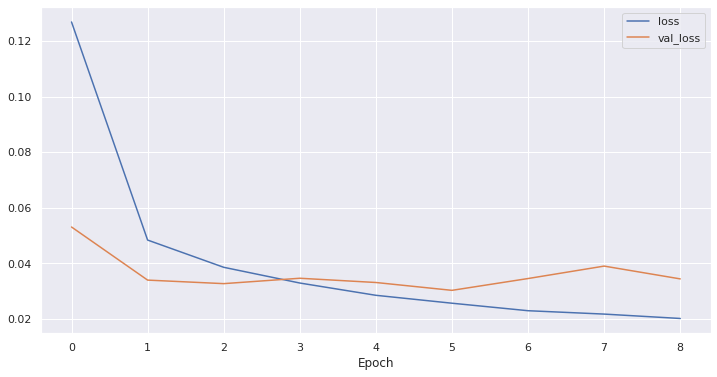

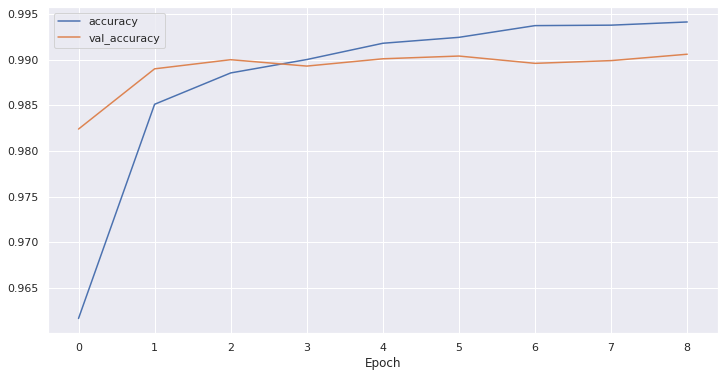

In [ ]:
# Plots for Model II
y_pred_2 = fit.model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(fit.history['loss'], '-', label='loss')
plt.plot(fit.history['val_loss'], '-', label='val_loss')
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(fit.history['accuracy'], '-', label='accuracy')
plt.plot(fit.history['val_accuracy'], '-', label='val_accuracy')
plt.xlabel("Epoch")
plt.legend()
plt.show()

array([[ 977,    0,    0,    0,    0,    0,    2,    1,    0,    0],
       [   0, 1131,    2,    0,    0,    0,    1,    0,    1,    0],
       [   2,    3, 1017,    0,    1,    0,    2,    6,    1,    0],
       [   1,    1,    5,  984,    0,   10,    0,    5,    4,    0],
       [   0,    0,    0,    0,  962,    0,    5,    2,    1,   12],
       [   1,    0,    0,    2,    0,  880,    5,    2,    1,    1],
       [   8,    2,    1,    0,    0,    3,  942,    0,    1,    1],
       [   0,    3,    6,    1,    0,    0,    0, 1017,    0,    1],
       [   4,    0,    4,    0,    1,    1,    1,    3,  957,    3],
       [   1,    5,    0,    2,    4,    2,    1,    3,    2,  989]])

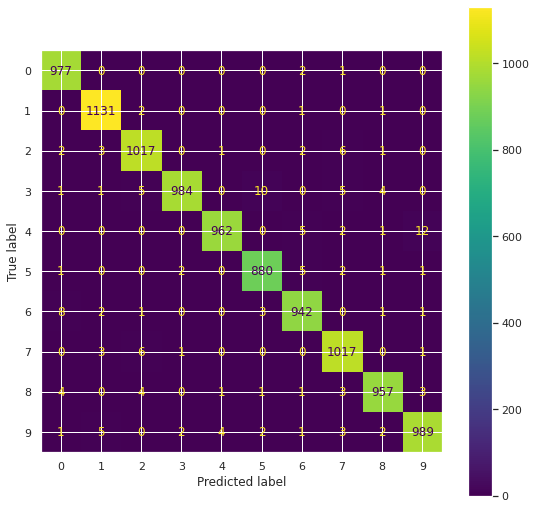

In [ ]:
# Confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_1, axis=1))
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(9, 9))
cmp.plot(ax=ax)
cm

#### Przewidywania i pomyłki modelu II
Przykłady z graficzną prezentacją

##### Przewidywia modelu II
Poniżej przedstawiam kilka pierwszych próbek ze zbioru testowego wraz z odpowiedzią, do jakiej kategorii zostały zaklasyfikowane.

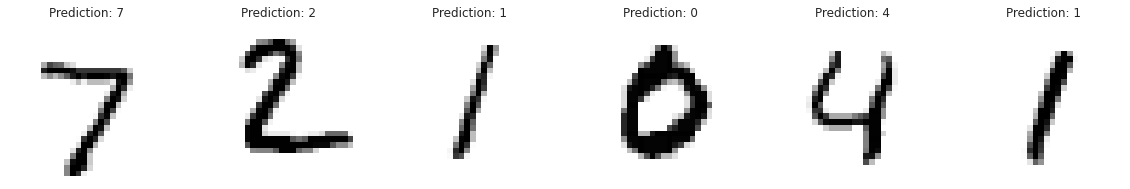

In [ ]:
# Show predictions
y_pred2 = np.argmax(y_pred_2, axis=1)
_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for ax, image, prediction in zip(axes, X_test, y_pred2):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

##### Pomyłki modelu II
Poniżej przedstawiam kilka pierwszych próbek ze zbioru testowego, które zostały zaklasyfikowane **błędnie**. Pierwsza cyfra oznacza prawidłową odpowiedź, a za nią znajduje się odpowiedź modelu.

Misclassified on indexes:  [184 321 582 591 659 684 717 726 846 947]  (first 10)


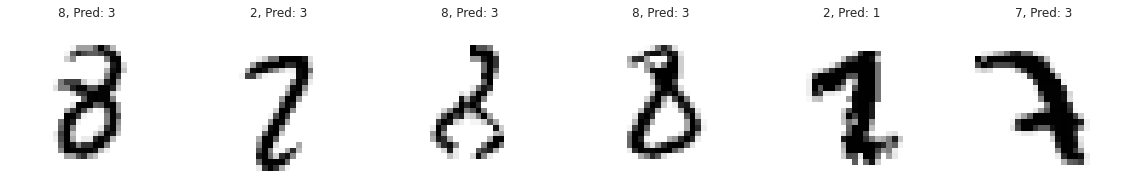

In [ ]:
# Get indexes of misclassifications
y_test_arg = np.argmax(y_test, axis=1)
mscl = y_test_arg != y_pred2
mscl = mscl.nonzero()[0]
X_test_mscl = X_test[mscl]
y_pred_mscl = y_pred2[mscl]
y_correct_mscl = y_test_arg[mscl]
print("Misclassified on indexes: ", mscl[:10], " (first 10)")

# Show misclassifications

_, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for ax, image, prediction, correct in zip(axes, X_test_mscl, y_pred_mscl, y_correct_mscl):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"{correct}, Pred: {prediction}")

## Podsumowanie
Oba modele są oparte o sieci konwolucyjne.
Pierwszy model ma dodatkową wartswę ukrytą a crugi model ma bogatszą strukturę sieci konwolucyjnej.
Widać, że zwiększenie liczby parametrów wejściowych (z warstwy konwolucyjnej) nawet mimo zmniejszenia liczby ogólnych parametrów (usunięcie warstwy ukrytej) pozytywnie wpłynęło na skuteczność modelu - osiągnął delikatnie lepsze wyniki (przekroczył 99%).

Oba modele osiągnęły wyższą skuteczność niż poprzednie modele oparte na perceptronie.

Uwaga: Niektóre przykłady źle zaklasyfikowanych cyfr są takie, że i człowiek może mieć przy nich problemy, gdyż są niewyraźne lub nietypowe. Podejrzewam, że zbudowanie modelu o 100% skuteczności dla tego zbioru cyfr jest niemal niemożliwe.